# practice doing some ML on final files - all particle stats 
## (envi measures + particle statistics)
instantaneous measurements of other environemental variables when particles were imaged.

In [2]:
#import iris
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
from datetime import datetime
import seaborn as sns

## scaling data options:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

## PCA bits
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d 

## k-means bits
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

# these are the evaluation parts
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
)

In [2]:
## practice files (so i don't break them)
data_path = '/home/users/esree/data/particle_sampling/'
#particle_csv = 'v4_2_flight_220730153000.csv'
## using 64 hz MO data
#nc_file = 'metoffice-nevzorov_faam_20220730_r0_c307_64hz.nc' 
## faam data
#nc2_file = 'core_faam_20220730_v005_r0_c307_1hz.nc'

# processed csv
processed_csv = '220730153000_envi_stats.csv'

In [9]:
# date info 
dd = particle_csv[-12:-10]
mm = particle_csv[-14:-12]
yy = particle_csv[-16:-14]

date = f'20{yy}-{mm}-{dd}'

# open files
csv_data = pd.read_csv(data_path+particle_csv)
nc_MO = xr.open_mfdataset(data_path+nc_file)
nc_faam = xr.open_mfdataset(data_path+nc2_file)

# correct csv time (so match format of nc files)  yyyy-mm-ddThh:mm:ss.ssssss
start_t = date + "T" + csv_data['start_time']
end_t = date + "T" + csv_data['end_time']
same_t = [start_t == end_t for start_t, end_t in zip(start_t,end_t)] # bool - if start = end time
start_end_t = list(zip(start_t, end_t, same_t)) # zipped together, for easy access 

## subsection of times to practice
reduc_t = start_end_t[:10]
reduc_t

[('2022-07-30T16:51:13.374000000', '2022-07-30T16:51:13.374000000', True),
 ('2022-07-30T16:51:14.731000000', '2022-07-30T16:51:14.778000000', False),
 ('2022-07-30T16:51:14.778000000', '2022-07-30T16:51:14.778000000', True),
 ('2022-07-30T16:51:14.825000000', '2022-07-30T16:51:14.825000000', True),
 ('2022-07-30T16:51:14.825000000', '2022-07-30T16:51:14.825000000', True),
 ('2022-07-30T16:51:15.028000000', '2022-07-30T16:51:15.028000000', True),
 ('2022-07-30T16:51:15.480000000', '2022-07-30T16:51:15.480000000', True),
 ('2022-07-30T16:51:15.777000000', '2022-07-30T16:51:16.323000000', False),
 ('2022-07-30T16:51:16.323000000', '2022-07-30T16:51:16.323000000', True),
 ('2022-07-30T16:51:17.087000000', '2022-07-30T16:51:17.087000000', True)]

In [19]:
## faam process
faam_vars = {'wind_w':'W_C', 'air_temp':'TAT_DI_R', 'pres':'P10_STAT', 'alt':'ALT_GIN','temp':'TAT_DI_R'}
faam_keys = list(faam_vars.keys())

for t in reduc_t:
    for k in faam_keys:
        
        print(faam_vars[k])

#for k in faam_keys

W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R
W_C
TAT_DI_R
P10_STAT
ALT_GIN
TAT_DI_R


In [18]:
faam_keys

['wind_w', 'air_temp', 'pres', 'alt', 'temp']

In [ ]:
nc_MO.close()
nc_faam.close()

# an all csv file data - containing all 2ds ch0 stats


In [15]:
#data_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/2ds/ch_0/particle_stats/'
data_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/'

#processed_csv = 'all_ch_0.csv'
ds_hvps_csv = 'all_2ds_hvps.csv'
ds_csv = '2ds/all_2ds.csv'

one_file = '2ds/ch_0/particle_stats/220727160906_envi_stats.csv'


In [16]:
#df = pd.read_csv(data_path+processed_csv)
#df = pd.read_csv(data_path+ds_hvps_csv)
df = pd.read_csv(data_path+one_file) 
#df = pd.read_csv(data_path+processed_csv)

# only consider particle that are relevent:
## importantly, there are some nans in LWC / IWC, so want to filter them out too
reduced_csv = df[
    (df['Euclidean_d_max'] >= 300) &
    (df['first_diode_trunc'] == 0) &
    (df['last_diode_trunc'] == 0) &
    (df['image_trunc'] == 0) &
    (~df.isnull().any(axis=1))]  # Exclude rows with NaN

subset2_noname = reduced_csv[['Euclidean_d_max','wind_w','pres','LWC','IWC']] #'Euclidean_d_max', 'temp',

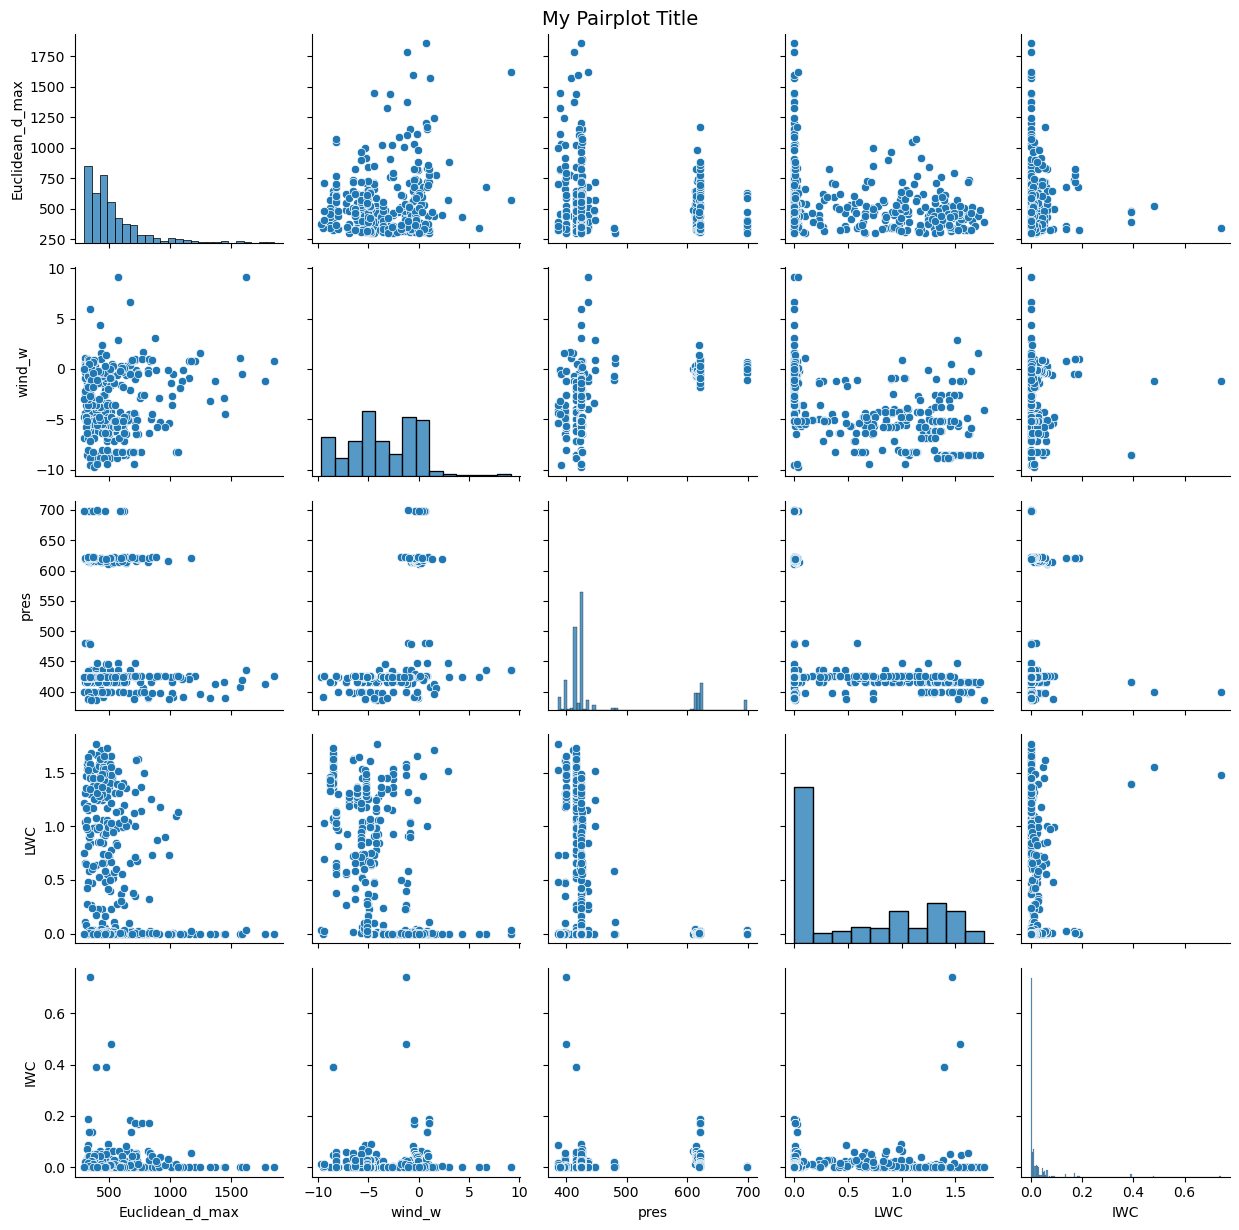

In [26]:
save_loc = '/home/users/esree/2DS_code/unsupervised_ML/plots/'

g = sns.pairplot(subset2_noname)

g.fig.suptitle('My Pairplot Title', fontsize=14)

# Adjust layout to ensure the title is included
plt.tight_layout()

# Save the figure, specifying padding for the bounding box
plt.savefig(save_loc+'foo.png', bbox_inches='tight')
plt.show()

# load example data, so we don't accidently ruin actual csv files
## one day only - 30th July!

In [13]:
data_path = '/home/users/esree/data/particle_sampling/'
processed_csv = '220730153000_envi_stats.csv'

df = pd.read_csv(data_path+processed_csv)

# only consider particle that are relevent:
## importantly, there are some nans in LWC / IWC, so want to filter them out too
reduced_csv = df[
    (df['Euclidean_d_max'] >= 300) &
    (df['first_diode_trunc'] == 0) &
    (df['last_diode_trunc'] == 0) &
    (df['image_trunc'] == 0) &
    (~df.isnull().any(axis=1))]  # Exclude rows with NaN


# consider only columns that are useful to ML
csv_subset = reduced_csv[['name','wind_w','pres','temp','LWC','IWC']]

csv_subset_2 = reduced_csv[['name','Euclidean_d_max','wind_w','pres','temp','LWC','IWC']]
subset2_noname = reduced_csv[['Euclidean_d_max','wind_w','pres','LWC','IWC']] #'Euclidean_d_max', 'temp',

start_time = df['start_time']
reduced_df_start_time =reduced_csv['start_time']

In [15]:
#subset2_noname.isnull().values.any()
rows_with_nan = csv_subset_2[csv_subset_2.isnull().any(axis=1)]
len(rows_with_nan)
reduced_df_start_time

0        16:51:13.374000000
37       16:55:28.887000000
51       16:55:30.088000000
60       16:55:30.229000000
66       16:55:30.525000000
                ...        
16938    19:17:42.598000000
16939    19:17:42.598000000
16942    19:17:43.799000000
16945    19:17:52.691000000
16947    19:17:53.347000000
Name: start_time, Length: 3793, dtype: object

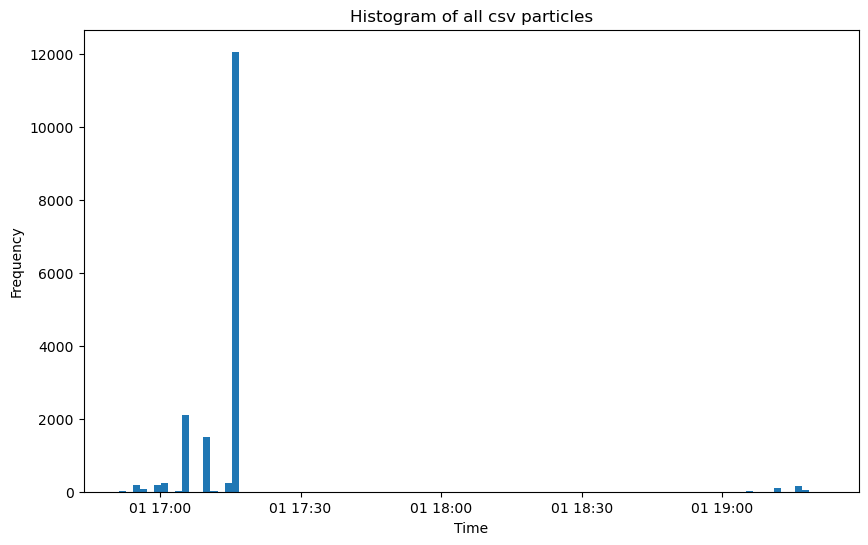

In [31]:
#reduced_df_start_time = pd.Series(reduced_df_start_time)

# Convert to datetime format
time_series = pd.to_datetime(start_time, format='%H:%M:%S.%f')

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(time_series, bins=100)  # Adjust bins as needed

# Set x-axis ticks for every hour
#plt.xticks(pd.date_range(start=time_series.min(), end=time_series.max()),rotation=45, ha='right')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of all csv particles')

# Display the plot
plt.show()


## inital plots of the data

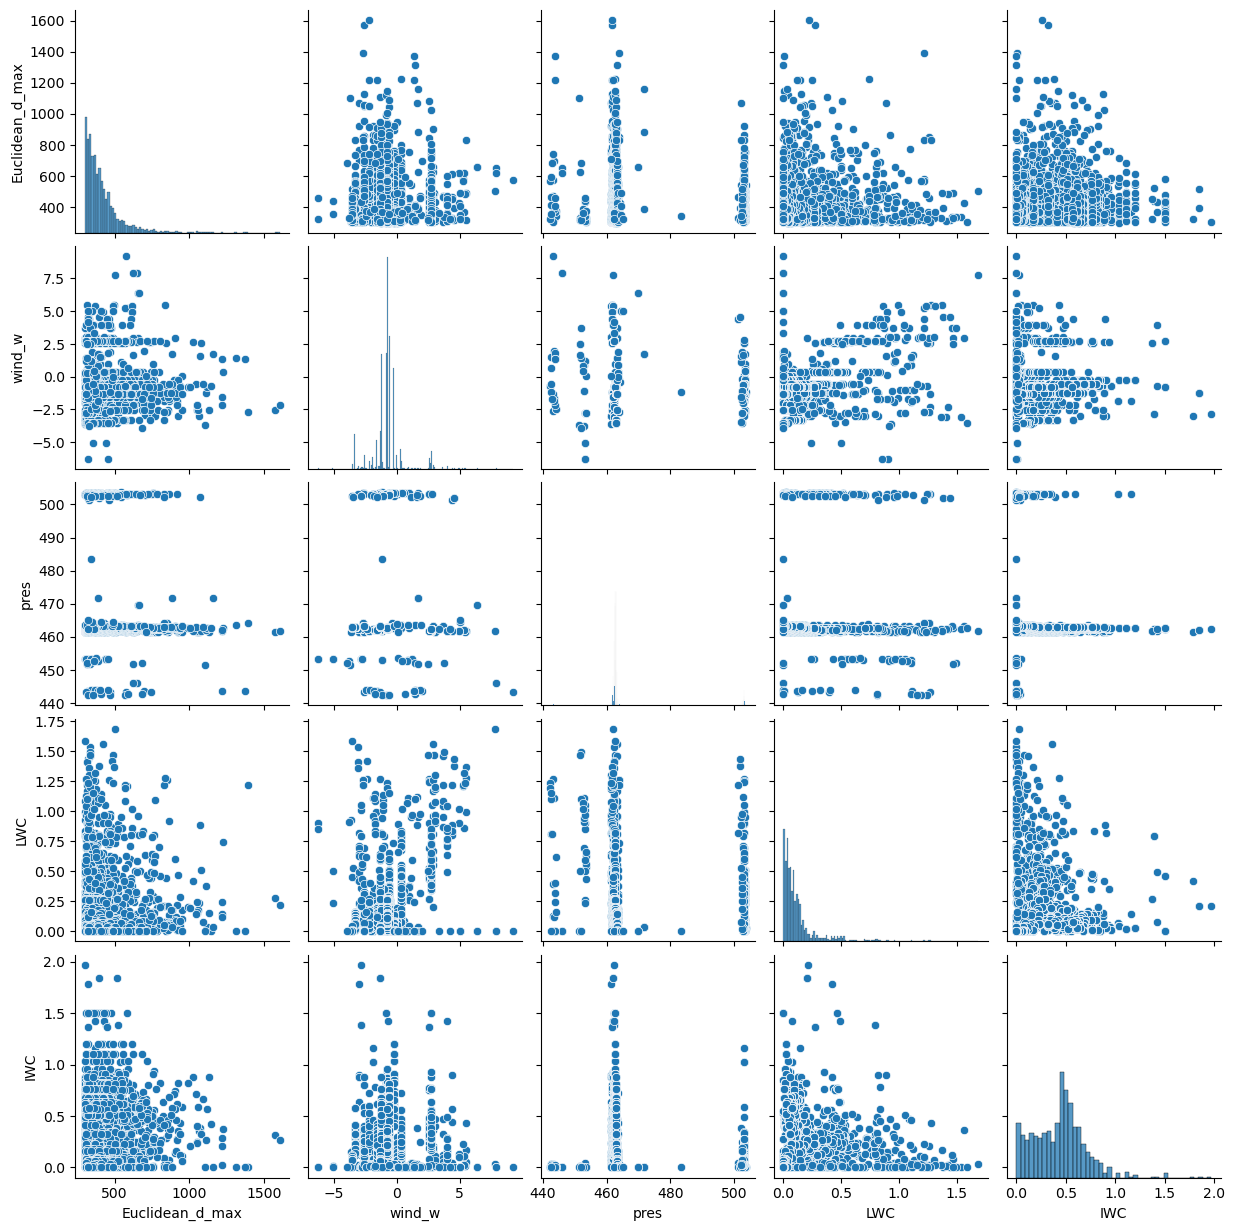

In [71]:
sns.pairplot(subset2_noname)
# to show
plt.show()

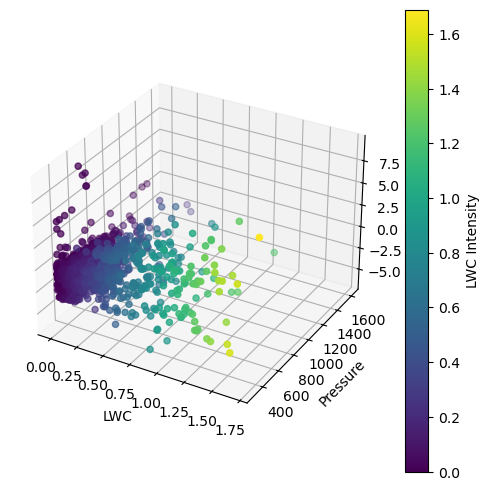

In [29]:
# Create a 3D figure
fig = plt.figure(figsize=(6, 6))

# Add a 3D subplot to the figure
ax = fig.add_subplot(111, projection='3d')

# Example data
x = csv_subset_2['LWC']
#y = csv_subset_2['pres']
y = csv_subset_2['Euclidean_d_max']
z = csv_subset_2['wind_w']

# Create a 3D scatter plot
sc = ax.scatter(x, y, z, c=x) #, cmap='viridis', marker='o')

# Add axis labels
ax.set_xlabel('LWC')
ax.set_ylabel('pres')
ax.set_zlabel('Wind W')

# Optionally, add a colorbar
plt.colorbar(sc, ax=ax, label='LWC Intensity')

# Show the plot
plt.show()

<Axes: xlabel='Euclidean_d_max', ylabel='wind_w'>

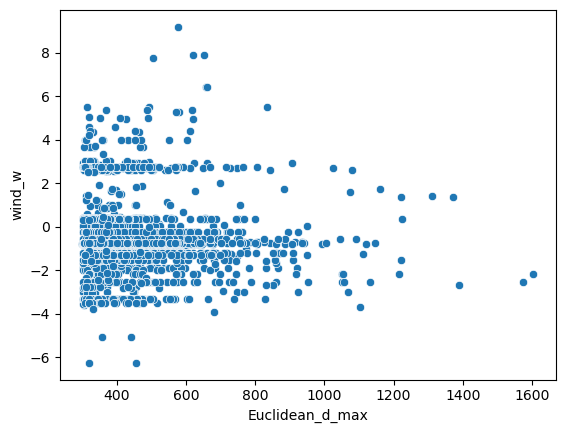

In [34]:
var1 = 'Euclidean_d_max'
var2 = 'wind_w'
sns.scatterplot(data = csv_subset_2, x = var1, y = var2)


# scaling the data

As the environmental variables we are using have vastly different quantities - i.e. pressure (100s hPa) is a lot bigger than IWC (1s g/m3), the values need to be normalised.

In [8]:
subset2_noname ## inital data

,wind_w,pres,LWC,IWC
0,-1.166530,483.49713,0.000000,0.000000
37,-0.246871,503.13100,0.003801,0.003182
51,-0.011994,503.28754,0.001855,0.021077
60,-0.011994,503.28754,0.004551,0.007240
66,0.453234,503.32050,0.002298,0.000447
...,...,...,...,...
16938,4.995761,464.50830,0.000169,0.000000
16939,4.995761,464.50830,0.000169,0.000000
16942,5.024464,465.02118,0.000000,0.000000
16945,6.397759,469.74414,0.000000,0.000000


In [7]:
# # # couple methods to scaling # # # 
# 1. standardisation (Z-normalisation)
    # centres data (mean =0) + scales to have unit variance (std =1)
    # work well for most datasets
std_scaler = StandardScaler()
std_scaled_data = std_scaler.fit_transform(subset2_noname) # apply scale
std_scaled_df = pd.DataFrame(std_scaled_data, columns=subset2_noname.columns)
#std_scaled_df

# 2. Min-Max Scaling
    # data to a fixed range, normally (0,1)
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(subset2_noname) # apply scale
minmax_scaled_df = pd.DataFrame(minmax_scaled_data, columns=subset2_noname.columns)
#minmax_scaled_df

# 3. Robust scaling
    # scale based on interquartile range, so is robust to outliers
    # useful if extreme outliers present
rob_scaler = RobustScaler()
rob_scaled_data = rob_scaler.fit_transform(subset2_noname)
rob_scaled_df = pd.DataFrame(rob_scaled_data, columns=subset2_noname.columns)
#rob_scaled_df
std_scaled_df

,Euclidean_d_max,wind_w,pres,LWC,IWC
0,-0.578399,-0.268027,0.725133,-0.399527,-1.152319
1,-0.916374,-0.220435,0.727043,-0.400497,-1.154675
2,-0.926127,-0.291537,0.723384,-0.400742,-1.151637
3,-0.702682,-0.291537,0.723384,-0.400742,-1.151637
4,-0.904375,-0.186106,0.723778,-0.400742,-1.063839
...,...,...,...,...,...
430565,0.299579,0.312050,1.016769,6.125924,-1.169421
430566,2.482115,0.446051,1.007614,6.418199,-1.169421
430567,1.837696,0.251262,1.008678,6.429033,-1.169421
430568,2.683918,0.251262,1.008678,6.429033,-1.169421


# PCA analysis

In [8]:
#X_reduced_3 = PCA(n_components=3).fit_transform(subset2_noname)
#X_reduced_2 = PCA(n_components=2).fit_transform(subset2_noname)

#X_reduced_3 = PCA(n_components=3).fit_transform(minmax_scaled_df)
#X_reduced_2 = PCA(n_components=2).fit_transform(minmax_scaled_df)

X_reduced_3 = PCA(n_components=3).fit_transform(std_scaled_df)
X_reduced_2 = PCA(n_components=2).fit_transform(std_scaled_df)

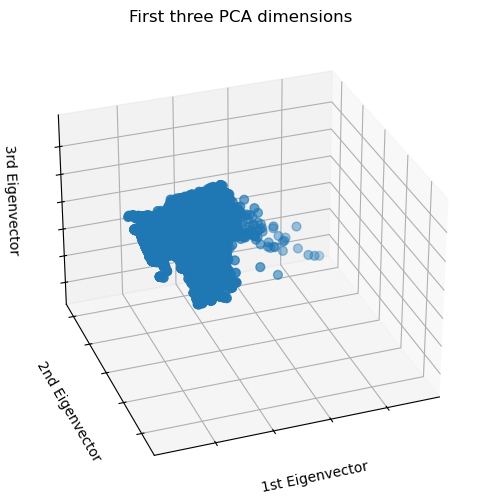

In [9]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

scatter = ax.scatter(
    X_reduced_3[:, 0],
    X_reduced_3[:, 1],
    X_reduced_3[:, 2],
    s=40,
)

ax.set(
    title="First three PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
    zlabel="3rd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

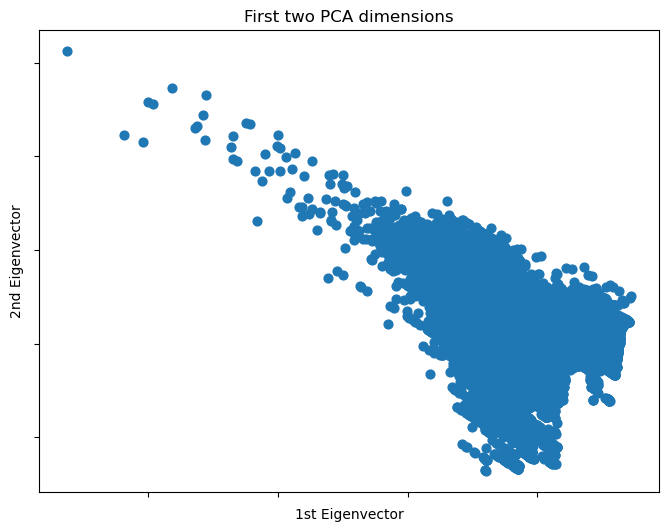

In [28]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111) #, elev=-150, azim=110)

scatter = ax.scatter(
    X_reduced_2[:, 0],
    X_reduced_2[:, 1],
)

ax.set(
    title="First two PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.show()

# scikit-learn k-Means

In [ ]:
## using scikit example to build a function
# scales the data and applies k-means
#class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, 
    # verbose=0, random_state=None, copy_x=True, algorithm='lloyd')


def apply_k_means(kmeans_init, data, labels, scaling_method="StandardScaler"):
    """quick all inclusive function to apply kmeans.
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()

    # Choose scaling method based on the input
    if scaling_method == "StandardScaler":
        scaler = StandardScaler()
    elif scaling_method == "MinMaxScaler":
        scaler = MinMaxScaler()
    elif scaling_method == "RobustScaler":
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unsupported scaling method: {scaling_method}")

    # Scale the data
    scaled_data = scaler.fit_transform(data)

    estimator = make_pipeline(kmeans).fit(scaled_data)
        
    fit_time = time() - t0
    results = [fit_time, estimator[-1].inertia_]

    # evaluation metrics, just looking at clusters 
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return 

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# function to evaluate k-means
def evaluate_kmeans(data, labels, ground_truth=None):
    """
    Evaluate the performance of KMeans clustering.

    Parameters
    ----------
    data : ndarray of shape (n_samples, n_features)
        The scaled data used for clustering.
    labels : ndarray of shape (n_samples,)
        The cluster labels predicted by KMeans.
    ground_truth : ndarray of shape (n_samples,), optional
        The true labels for the dataset, if available. Default is None.

    Returns
    -------
    results : dict
        A dictionary of evaluation metrics and their values.
    """
    results = {}

    # Compute metrics that don't require ground truth
    results['Silhouette Score'] = silhouette_score(data, labels)
    results['Calinski-Harabasz Index'] = calinski_harabasz_score(data, labels)
    results['Davies-Bouldin Index'] = davies_bouldin_score(data, labels)

    # Compute metrics that require ground truth (if provided)
    if ground_truth is not None:
        results['Homogeneity Score'] = homogeneity_score(ground_truth, labels)
        results['Completeness Score'] = completeness_score(ground_truth, labels)
        results['V-Measure Score'] = v_measure_score(ground_truth, labels)
        results['Adjusted Rand Index'] = adjusted_rand_score(ground_truth, labels)
        results['Adjusted Mutual Information'] = adjusted_mutual_info_score(ground_truth, labels)

    return results


In [28]:
## step by step apply kmeans on our data (following scikit example)
#  ! subset2_noname !

kmean_mtd = KMeans(init="k-means++", random_state=0)
    # init -> couple different method for initilising kmeans
    # n_clusters -> number of clusters / number centroids to make
    # n_init -> number of times the kmeans is ran e.g. 4 times - 4 different starting clusters, then choose best
        # 
    # random_state -> seed for random number
scale_method = StandardScaler() # MinMaxScaler # RobustScaler

t0 = time()
estimator = make_pipeline(StandardScaler(), kmean_mtd).fit(subset2_noname)
fit_time = time() - t0
results = [fit_time, estimator[-1].inertia_]

In [29]:
results

[0.010739564895629883, 3089.332641553399]

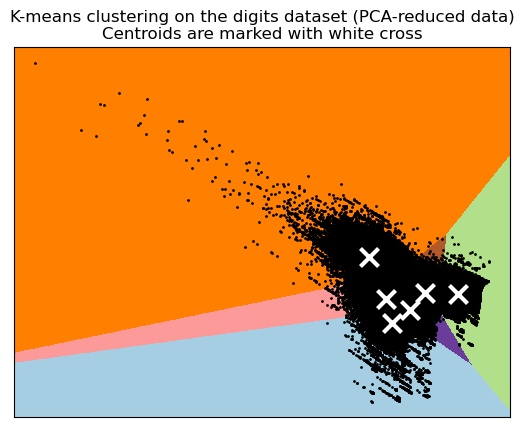

In [11]:

reduced_data = PCA(n_components=2).fit_transform(std_scaled_df)
kmeans = KMeans(init="k-means++", n_clusters=6, n_init=10, random_state=0)

kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
seed_random = 1

fitted_kmeans = {}
labels_kmeans = {}
df_scores = []
k_values_to_try = np.arange(2, 31)
for n_clusters in k_values_to_try:
    
    #Perform clustering.
    kmeans = KMeans(n_clusters=n_clusters,
                    random_state=seed_random,
                    )
    labels_clusters = kmeans.fit_predict(X)
    
    #Insert fitted model and calculated cluster labels in dictionaries,
    #for further reference.
    fitted_kmeans[n_clusters] = kmeans
    labels_kmeans[n_clusters] = labels_clusters
    
    #Calculate various scores, and save them for further reference.
    silhouette = silhouette_score(X, labels_clusters)
    ch = calinski_harabasz_score(X, labels_clusters)
    db = davies_bouldin_score(X, labels_clusters)
    tmp_scores = {"n_clusters": n_clusters,
                  "silhouette_score": silhouette,
                  "calinski_harabasz_score": ch,
                  "davies_bouldin_score": db,
                  }
    df_scores.append(tmp_scores)

#Create a DataFrame of clustering scores, using `n_clusters` as index, for easier plotting.
df_scores = pd.DataFrame(df_scores)
df_scores.set_index("n_clusters", inplace=True)

In [88]:
n_clusters = []
inertia_testing = []
scale_method = StandardScaler() # MinMaxScaler # RobustScaler
for i in range(1,21):
    kmean_mtd = KMeans(init="k-means++",n_clusters=i,n_init=10, random_state=0)
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmean_mtd).fit(std_scaled_df)
    fit_time = time() - t0
    results = [fit_time, estimator[-1].inertia_]
    n_clusters.append(i)
    inertia_testing.append(results[1])

In [89]:
inertia_testing

[18965.000000000004,
 14490.724488054224,
 10956.062521690697,
 9064.546005073411,
 7425.093220747091,
 6734.125981430363,
 6092.25710329391,
 5611.849222792711,
 5029.712161970455,
 4624.527336627728,
 4434.155474177871,
 4135.704789195052,
 3951.648188422351,
 3768.3883709175343,
 3640.1688501479844,
 3503.574882303276,
 3400.723964595468,
 3198.248131901794,
 3147.205235600812,
 2991.8803870273305]

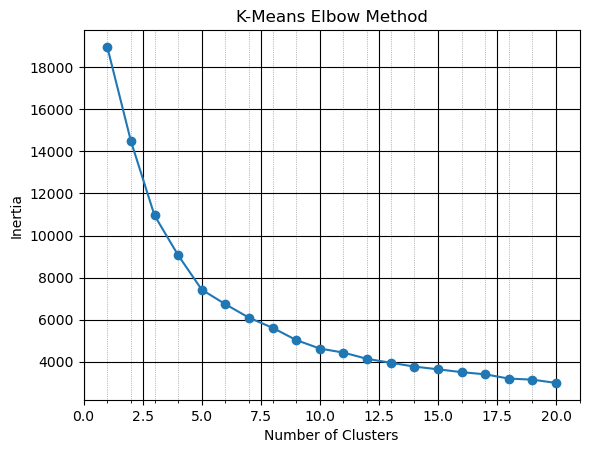

In [90]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(n_clusters, inertia_testing, marker='o', label="Inertia")
ax.set_xlim(min(n_clusters)-1, max(n_clusters)+1)

# Set spacing for minor ticks
spacing = 1  # User-specified spacing
minorLocator = MultipleLocator(spacing)

# Apply minor ticks to the x-axis
ax.xaxis.set_minor_locator(minorLocator)

# Enable grid for minor ticks
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.grid(which='major', linestyle='-', linewidth='0.8', color='black')

# Labels and title
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_title('K-Means Elbow Method')

# Show the plot
plt.show()
